# **Abstract**

This project focuses on predicting loan repayment outcomes using a real-world lending dataset containing financial, demographic, and loan-related attributes from Kaggle. Our goal is to develop machine learning models capable of identifying whether a borrower is likely to repay a loan, a task that is essential for risk assessment and credit decision-making. We employ three different classification approaches: Logistic Regression, K-Nearest Neighbors (KNN), and Random Forest. A consistent preprocessing pipeline, missing-value imputation, feature scaling, and OHE are applied to ensure fair model comparison across all methods.

## **Inports**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from google.colab import drive
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline



## **Load Data**

In [ ]:
# load dataset
train = pd.read_csv("train.csv") # load training set
test = pd.read_csv("test.csv") # load test set

# train = pd.read_csv("/content/sample_data/train.csv")
# test = pd.read_csv("/content/sample_data/test.csv")
# print head and shape
print("Train head:\n", train.head(), "\n")
print("Test head:\n", test.head(), "\n")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train head:
    id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     High School          Employed   
3          16.10  Female         Single     High School          Employed   
4          10.21    Male        Married     High School          Employed   

         loan_purpose grade_subgrade  loan_paid_back  
0               Other         

## **Removing the ID Column**
The id column was removed from both the training and test datasets since it does not provide predictive information for the loan repayment target. After dropping this column, the training matrix contained 11 features, and the raw test matrix also contained 11 features.

In [ ]:
TARGET = "loan_paid_back"

y = train[TARGET]
# drop id
X = train.drop(columns=[TARGET, "id"])
X_test_raw = test.drop(columns=["id"])

test_id = test["id"]

print("After removing id, X shape:", X.shape)
print("X_test_raw shape:", X_test_raw.shape)

After removing id, X shape: (593994, 11)
X_test_raw shape: (254569, 11)


# **Data split**
The dataset was split into training (75%) and validation (25%) sets using stratified sampling to preserve class balance. The same split was used for all models to ensure fair comparison.

In [74]:
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)
print("Training set shape: ", X_train_raw.shape)
print("Validation set shape:", X_val_raw.shape)


Training set shape:  (445495, 11)
Validation set shape: (148499, 11)


## **Identifying Numerical and Categorical Features**
All features were separated into numerical and categorical groups based on their data types. Numerical features included variables such as income, debt-to-income ratio, credit score, and loan amount. Categorical features included variables such as gender, marital status, education level, employment status, loan purpose, and grade subgrade.
This separation allowed the preprocessing pipeline to apply the appropriate transformations to each feature type.

In [ ]:
# numeric and categorical
numeric_cols = X_train_raw.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X_train_raw.select_dtypes(include=["object"]).columns


print("Numeric columns:", list(numeric_cols))
print("Categorical columns:", list(categorical_cols))

Numeric columns: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
Categorical columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


# **Preprocessing**
A preprocessing pipeline was built using **ColumnTransformer**.
For numerical features, the pipeline applied median imputation to fill missing values and standardized the columns using **StandardScaler**.
For categorical features, the pipeline used the most frequent category for imputation and then applied one-hot encoding, with unseen categories handled safely during inference.

In [ ]:
# pipeline fit once
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))])
preprocessor = ColumnTransformer(transformers=[("numeric", numeric_transformer, numeric_cols), ("categorical", categorical_transformer, categorical_cols)])

# **Logistic** **regression**
Logistic Regression was adopted as a baseline model due to its simplicity and interpretability. L2 regularization was applied to improve generalization in the presence of correlated predictors and high-dimensional one-hot encoded features. The model was trained using a preprocessing pipeline and evaluated on a validation set using accuracy and ROC-AUC.

In [ ]:
lr_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(C=1e-3, max_iter=1000, solver="lbfgs", n_jobs=-1))
])


In [ ]:
lr_pipe.fit(X_train_raw, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object'))])),
                ('clf', LogisticRegression(C=0.001, max_iter=1000, n_jobs=-1))])

In [ ]:
y_val_pred_lr  = lr_pipe.predict(X_val_raw)
y_val_proba_lr = lr_pipe.predict_proba(X_val_raw)[:, 1]

print(f"Validation Accuracy : {accuracy_score(y_val, y_val_pred_lr):.4f}")
print(f"Validation ROC-AUC  : {roc_auc_score(y_val, y_val_proba_lr):.4f}")


Validation Accuracy : 0.8999
Validation ROC-AUC  : 0.9077


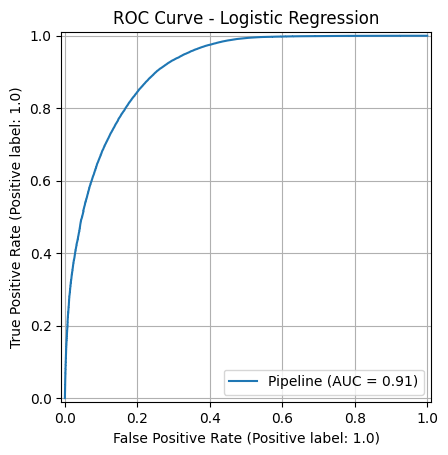

In [ ]:
RocCurveDisplay.from_estimator(lr_pipe, X_val_raw, y_val)
plt.title("ROC Curve - Logistic Regression")
plt.grid(True)
plt.show()


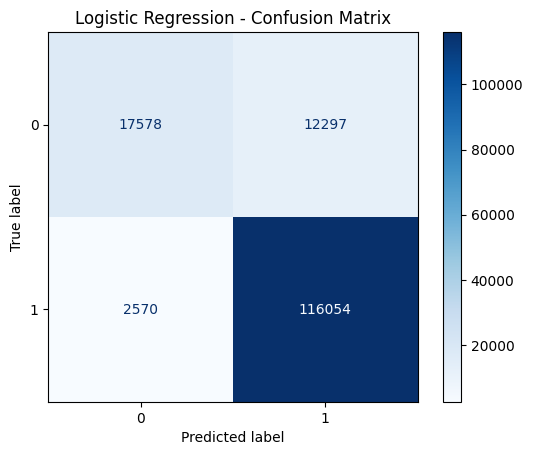

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

# **KNN**

K-Nearest Neighbors (KNN) was used as a non-parametric baseline classifier. To address computational constraints, the model was trained on a stratified subset of the training data, with TruncatedSVD applied for dimensionality reduction. Performance was evaluated using accuracy and ROC-AUC on a validation set.

In [ ]:
KNN_TRAIN_FRAC = 0.1

X_train_knn_raw, _, y_train_knn, _ = train_test_split(
    X_train_raw, y_train,
    train_size=KNN_TRAIN_FRAC,
    random_state=42,
    stratify=y_train
)

print("Full train:", X_train_raw.shape, "Val:", X_val_raw.shape)
print("KNN train subset:", X_train_knn_raw.shape)


Full train: (445495, 11) Val: (148499, 11)
KNN train subset: (44549, 11)


In [ ]:
from sklearn.decomposition import TruncatedSVD
svd_components = 20

# try different k value
candidate_k = [3, 5, 7, 11, 15, 21]

val_accs = []

for k in candidate_k:
    print(
        f"\nTraining SVD+KNN with k={k}, "
        f"n_components={svd_components} "
        f"(train subset frac={KNN_TRAIN_FRAC})"
    )

    knn_pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("svd", TruncatedSVD(n_components=svd_components, random_state=42)),
        ("knn", KNeighborsClassifier(
            n_neighbors=k,
            weights="distance",
            n_jobs=-1
        ))
    ])

    knn_pipe.fit(X_train_knn_raw, y_train_knn)
    val_pred = knn_pipe.predict(X_val_raw)

    acc = accuracy_score(y_val, val_pred)
    val_accs.append(acc)
    print(f"Validation Accuracy = {acc:.4f}")




Training SVD+KNN with k=3, n_components=20 (train subset frac=0.1)
Validation Accuracy = 0.8660

Training SVD+KNN with k=5, n_components=20 (train subset frac=0.1)
Validation Accuracy = 0.8758

Training SVD+KNN with k=7, n_components=20 (train subset frac=0.1)
Validation Accuracy = 0.8792

Training SVD+KNN with k=11, n_components=20 (train subset frac=0.1)
Validation Accuracy = 0.8824

Training SVD+KNN with k=15, n_components=20 (train subset frac=0.1)
Validation Accuracy = 0.8831

Training SVD+KNN with k=21, n_components=20 (train subset frac=0.1)
Validation Accuracy = 0.8834


In [ ]:
# use the best k to train the entire set
best_index = int(np.argmax(val_accs))
best_k = candidate_k[best_index]
best_acc = val_accs[best_index]

print("\nCandidate k:", candidate_k)
print("Validation accuracies:", [round(a, 4) for a in val_accs])
print(f"Best k is {best_k} with accuracy = {best_acc:.4f}")


Candidate k: [3, 5, 7, 11, 15, 21]
Validation accuracies: [0.866, 0.8758, 0.8792, 0.8824, 0.8831, 0.8834]
Best k is 21 with accuracy = 0.8834


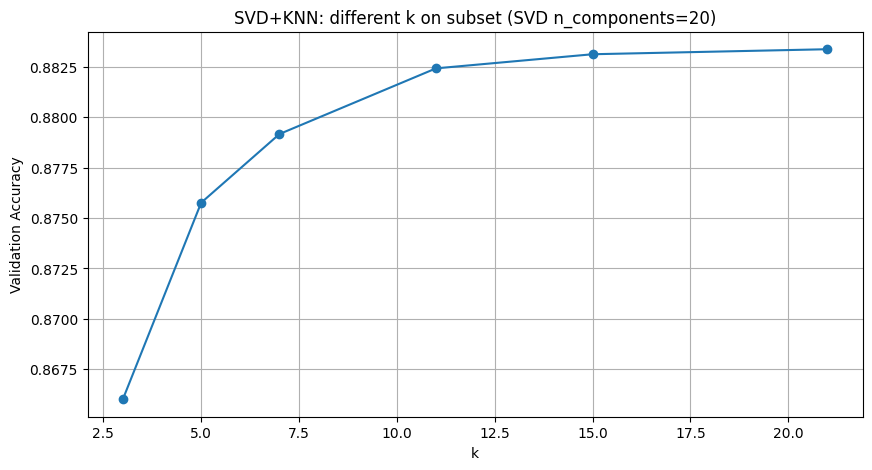

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(candidate_k, val_accs, marker="o")
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title(f"SVD+KNN: different k on subset (SVD n_components={svd_components})")
plt.grid(True)
plt.show()

In [ ]:
final_knn = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("svd", TruncatedSVD(n_components=svd_components, random_state=42)),
    ("knn", KNeighborsClassifier(
        n_neighbors=best_k,
        weights="distance",
        n_jobs=-1
    ))
])

final_knn.fit(X_train_knn_raw, y_train_knn)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object'))])),
                ('svd', TruncatedSVD(n_components=20, random_state=42)),
                ('knn',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=21,
                                      weights='distance'))])

In [ ]:
knn_val_proba = final_knn.predict_proba(X_val_raw)[:, 1]
knn_val_pred = (knn_val_proba >= 0.5).astype(int)

knn_acc = accuracy_score(y_val, knn_val_pred)
knn_auc = roc_auc_score(y_val, knn_val_proba)

print(f"\n[PCA+KNN] Validation Accuracy: {knn_acc:.4f}")
print(f"[PCA+KNN] Validation ROC-AUC:  {knn_auc:.4f}")


[PCA+KNN] Validation Accuracy: 0.8834
[PCA+KNN] Validation ROC-AUC:  0.8745


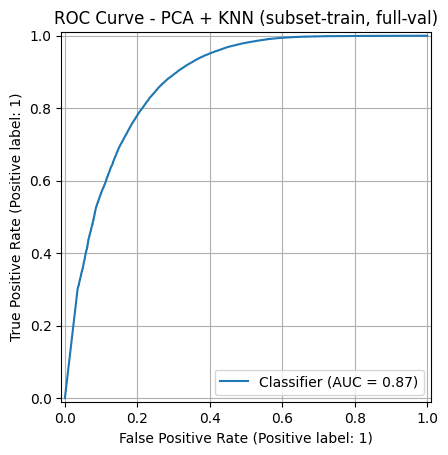

In [ ]:
RocCurveDisplay.from_predictions(y_val, knn_val_proba)
plt.title("ROC Curve - PCA + KNN (subset-train, full-val)")
plt.grid(True)
plt.show()


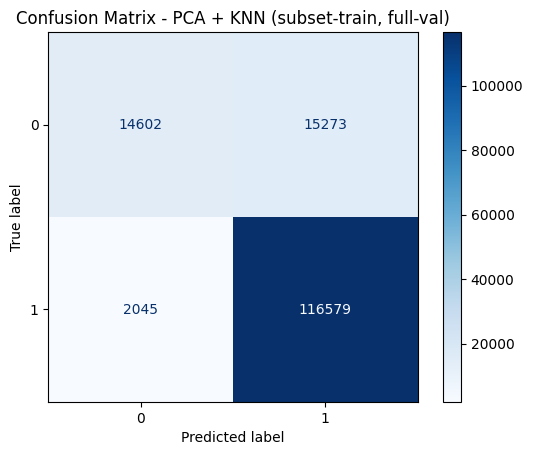

In [ ]:
# Confusion matrix for KNN
cm_knn = confusion_matrix(y_val, knn_val_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=[0, 1]).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - PCA + KNN (subset-train, full-val)")
plt.grid(False)
plt.show()

# **Random Forest**

Random Forest was used as a strong ensemble-based classifier capable of handling high-dimensional one-hot encoded features and capturing nonlinear interactions. The model was trained on a stratified subset of the training data for computational efficiency, with class weights applied to address class imbalance. Performance was evaluated using accuracy and ROC-AUC on a validation set.

In [ ]:
RF_TRAIN_FRAC = 0.15

X_train_rf_raw, _, y_train_rf, _ = train_test_split(
    X_train_raw, y_train,
    train_size=RF_TRAIN_FRAC,
    random_state=42,
    stratify=y_train
)

print("Full train:", X_train_raw.shape, "Val:", X_val_raw.shape)
print("RF train:", X_train_rf_raw.shape)


Full train: (445495, 11) Val: (148499, 11)
RF train: (66824, 11)


In [ ]:
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced_subsample"
    ))
])


In [ ]:
rf_pipe.fit(X_train_rf_raw, y_train_rf)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object'))])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_leaf=2, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

In [ ]:
rf_val_proba = rf_pipe.predict_proba(X_val_raw)[:, 1]
rf_val_pred  = (rf_val_proba >= 0.5).astype(int)

rf_acc = accuracy_score(y_val, rf_val_pred)
rf_auc = roc_auc_score(y_val, rf_val_proba)

print(f"[RF] Validation Accuracy: {rf_acc:.4f}")
print(f"[RF] Validation ROC-AUC:  {rf_auc:.4f}")

[RF] Validation Accuracy: 0.8968
[RF] Validation ROC-AUC:  0.9086


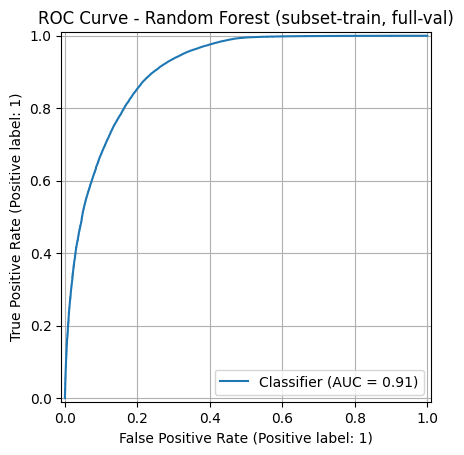

In [ ]:
RocCurveDisplay.from_predictions(y_val, rf_val_proba)
plt.title("ROC Curve - Random Forest (subset-train, full-val)")
plt.grid(True)
plt.show()

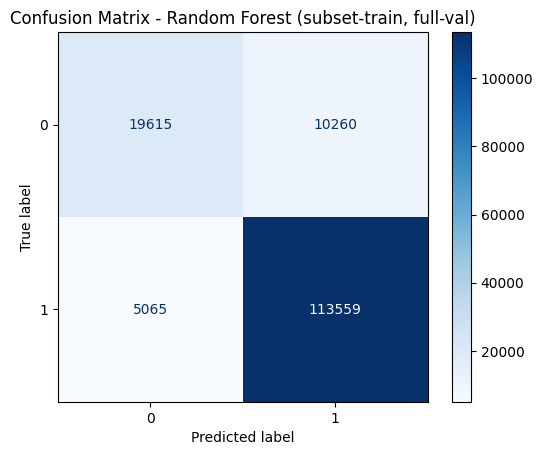

In [ ]:
# matrix plot
cm_rf = confusion_matrix(y_val, rf_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0,1])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest (subset-train, full-val)")
plt.grid(False)
plt.show()

# **Feature Importance (random forest)**

Feature importance was obtained from the trained Random Forest model, with one-hot encoded categorical features aggregated to the original feature level. Employment status, debt-to-income ratio, and credit score emerged as the most influential predictors.

In [ ]:
ct = rf_pipe.named_steps["preprocess"]
rf = rf_pipe.named_steps["rf"]

numeric_feature_names = list(numeric_cols)

ohe = ct.named_transformers_["categorical"].named_steps["ohe"]
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

importances = rf.feature_importances_

raw_cats = [name.split("_", 1)[0] for name in ohe_feature_names]

fi_raw_df = pd.DataFrame({
    "feature": numeric_feature_names + raw_cats,
    "importance": importances
})

fi_raw_df = (
    fi_raw_df
    .groupby("feature", as_index=False)["importance"]
    .sum()
    .sort_values("importance", ascending=False)
)

fi_raw_df.head(15)


,feature,importance
4,employment,0.405581
2,debt_to_income_ratio,0.181290
1,credit_score,0.099660
7,interest_rate,0.065213
0,annual_income,0.056816
9,loan_amount,0.056704
6,grade,0.050934
8,loan,0.029809
3,education,0.023255
10,marital,0.016701


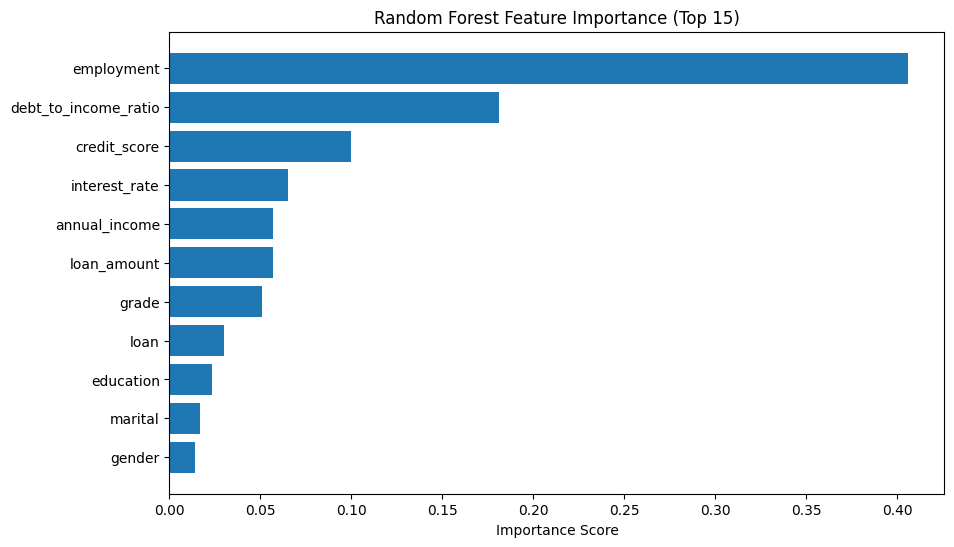

In [ ]:
top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(
    fi_raw_df.head(top_n)["feature"],
    fi_raw_df.head(top_n)["importance"]
)
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance (Top 15)")
plt.xlabel("Importance Score")
plt.show()


# **Final Model Selection and Test Prediction**
The Random Forest model was selected based on validation performance and retrained using the full pipeline. Probability predictions were then generated for the test set and saved for submission.

In [ ]:
best_model = rf_pipe
best_model.fit(X_train_rf_raw, y_train_rf)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object'))])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_leaf=2, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

In [ ]:
test_proba = best_model.predict_proba(X_test_raw)[:, 1]


In [ ]:
submission = pd.DataFrame({
    "id": test_id,
    "loan_paid_back": test_proba
})

submission.to_csv("submission.csv", index=False)
submission.head()


,id,loan_paid_back
0,593994,0.892122
1,593995,0.956886
2,593996,0.408036
3,593997,0.906116
4,593998,0.962698


In [ ]:
submission["loan_paid_back"].describe()


,loan_paid_back
count,254569.000000
mean,0.745955
std,0.289584
min,0.000000
25%,0.681069
50%,0.863547
75%,0.946403
max,0.999953
